# Modeling Cross Section Data with Decision Trees and Random Forest

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import sys
import os
sys.path.append("../..")

import nucml.datasets as nuc_data
import nucml.ensdf.plotting_utils as ensdf_plot
import nucml.ensdf.data_utilities as ensdf_utils
import nucml.ame.parsing_utilities as ame_utils
import nucml.model.model_building as model_building

In [2]:
import importlib
importlib.reload(nuc_data)
importlib.reload(ensdf_plot)
importlib.reload(model_building)
importlib.reload(ensdf_utils)

<module 'nucml.ensdf.data_utilities' from '../..\\nucml\\ensdf\\data_utilities.py'>

# Reading Cross Section Data into Dataframe

In [3]:
# ensdf_cutoff_df = nuc_data.load_ensdf(
#     sqrt=False, append_ame=True, basic=1, num=False, mode="cutoff")

In [4]:
# ensdf_df = nuc_data.load_ensdf(append_ame=True)
ensdf_df, _, _, _, _, _, _ = nuc_data.load_ensdf(
    cutoff=False, log_sqrt=True, append_ame=True, basic=1, num=True, frac=0.3, scaling_type="std")
ensdf_df = ensdf_df.drop(columns=["Parity_0.0"])

INFO:root:Reading data from ../../ENSDF/CSV_Files/ensdf.csv
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:\Users\Pedro\Desktop\ML_Nuclear_Data\AME\CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Dropping unnecessary features and one-hot encoding categorical columns...
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.
INFO:root:Finished. Resulting dataset has shape (72666, 16), Training and Testing dataset shapes are (50866, 15) and (21800, 15) respesctively.


In [5]:
ensdf_cutoff_df, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_ensdf(
    cutoff=True, log_sqrt=True, append_ame=True, basic=1, num=True, frac=0.3, scaling_type="std")

INFO:root:Reading data from ../../ENSDF/CSV_Files/ensdf_cutoff.csv
INFO:root:AME: Reading and loading Atomic Mass Evaluation files from: 
 C:\Users\Pedro\Desktop\ML_Nuclear_Data\AME\CSV_Files\AME_all_merged_no_NaN.csv
INFO:root:Dropping unnecessary features and one-hot encoding categorical columns...
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.
INFO:root:Finished. Resulting dataset has shape (21353, 15), Training and Testing dataset shapes are (14947, 14) and (6406, 14) respesctively.


In [ ]:
_, _, _, _, _, to_scale, scaler = nuc_data.load_ensdf(cutoff=True, log_sqrt=False, log=True, 
                                                      append_ame=True, basic=1, num=True, 
                                                      frac=0.3, scaling_type="std")



In [6]:
x_train.columns

Index(['Level_Number', 'Protons', 'Neutrons', 'Mass_Number', 'Spin',
       'Atomic_Mass_Micro', 'Mass_Excess', 'Binding_Energy', 'B_Decay_Energy',
       'S(2n)', 'S(n)', 'S(p)', 'Parity_-1.0', 'Parity_1.0'],
      dtype='object')

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [8]:
sample = ensdf_utils.load_ensdf_samples(ensdf_df, 92, 235)

Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (152, 15)


In [9]:
sample_exp = ensdf_utils.append_ensdf_levels(100, ensdf_df, 92, 235)

Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (152, 15)
Expanded Dataset has shape:  (99, 14)


In [11]:
sample_exp

,Level_Number,Protons,Neutrons,Mass_Number,Spin,Atomic_Mass_Micro,Mass_Excess,Binding_Energy,B_Decay_Energy,S(2n),S(n),S(p),Parity_-1.0,Parity_1.0
0,1,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
1,2,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
2,3,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
3,4,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
4,5,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
95,96,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
96,97,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1
97,98,92,143,235,0.5,2.350439e+08,40918.846,7590.914,-124.262,12142.96,5297.5,6709.05,0,1


# Decision Trees

We will try to fit a DT regressor with default parameters. 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [115]:
dt_saving_dir = '../Models/DT/'

In [116]:
if os.path.exists(dt_saving_dir):
    print("Directory Exists.")
else:
    print("Directory does not exists. Creating.")
    os.makedirs(dt_saving_dir)

Directory does not exists. Creating.


In [ ]:
dt_parameters = {"max_depth_list":np.arange(5, 45, 5), 
                 "min_split_list":[2, 5, 10, 15], 
                 "min_leaf_list":[1, 3, 5, 7, 10]}

dt_results = model_building.train_dt(x_train, y_train, x_test, y_test, dt_parameters, 
                                     save_models=True, save_dir=dt_saving_dir)

# Testing

In [46]:
importlib.reload(nuc_data)
importlib.reload(ensdf_plot)
importlib.reload(model_building)
importlib.reload(ensdf_utils)

<module 'nucml.ensdf.data_utilities' from '../..\\nucml\\ensdf\\data_utilities.py'>

In [14]:
from sklearn import tree
from sklearn.tree import plot_tree
# from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [15]:
dt_rgr = tree.DecisionTreeRegressor(max_depth=400, criterion='mse')
dt_rgr.fit(x_train, y_train)
print("The depth of the three is: ", dt_rgr.get_depth())

The depth of the three is:  31


In [37]:
figure_dir = "../Figures/"

Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (152, 15)
Extracting samples from dataframe.
Scaling dataset...
ENSDF extracted DataFrame has shape:  (152, 15)


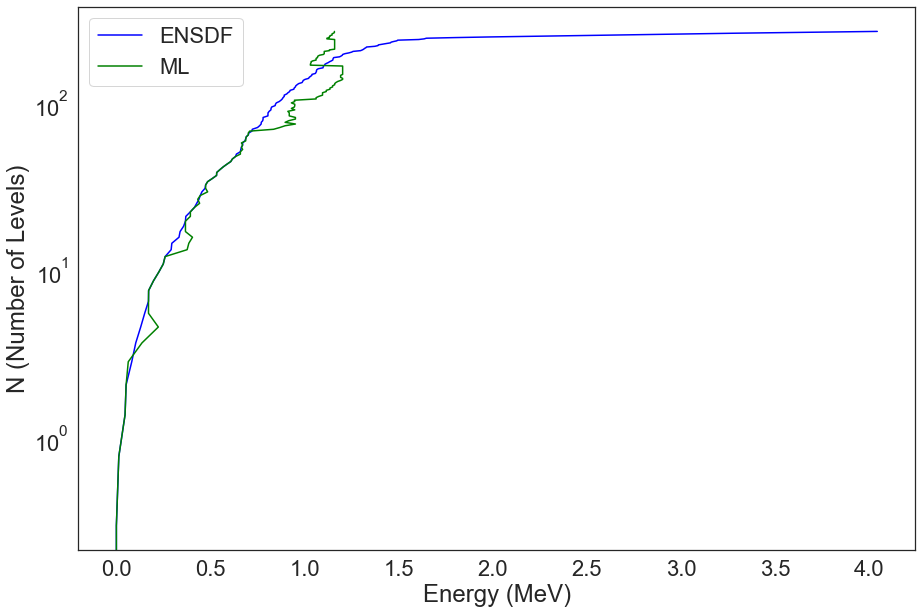

In [38]:
original, pred = ensdf_utils.make_predictions_from_df(
    ensdf_df, 92, 235, dt_rgr, None, scaler=scaler, 
    to_scale=to_scale, log_sqrt=True, plot=True, save=True,
    save_dir=figure_dir)

Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (53, 15)
Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (53, 15)
Expanded Dataset has shape:  (149, 14)
Scaling dataset...


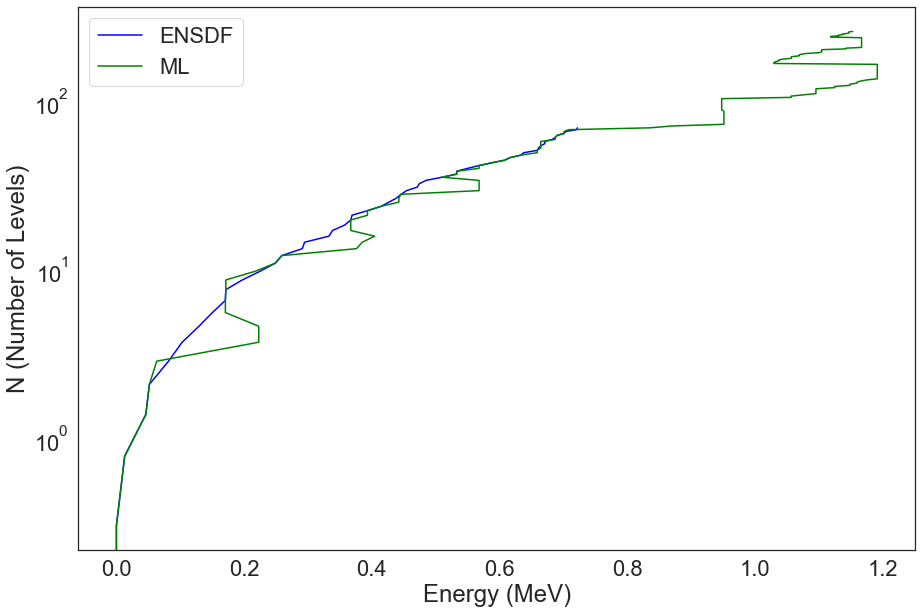

In [41]:
infer = ensdf_utils.make_predictions_w_levels(
    ensdf_cutoff_df, 92, 235, 150, dt_rgr, None, scaler=scaler, 
    to_scale=to_scale, log_sqrt=True, plot=True, save=True,
    save_dir=figure_dir)

Extracting samples from dataframe.
Scaling dataset...
ENSDF extracted DataFrame has shape:  (152, 15)
Extracting samples from dataframe.
ENSDF extracted DataFrame has shape:  (152, 15)
Expanded Dataset has shape:  (139, 14)
Scaling dataset...


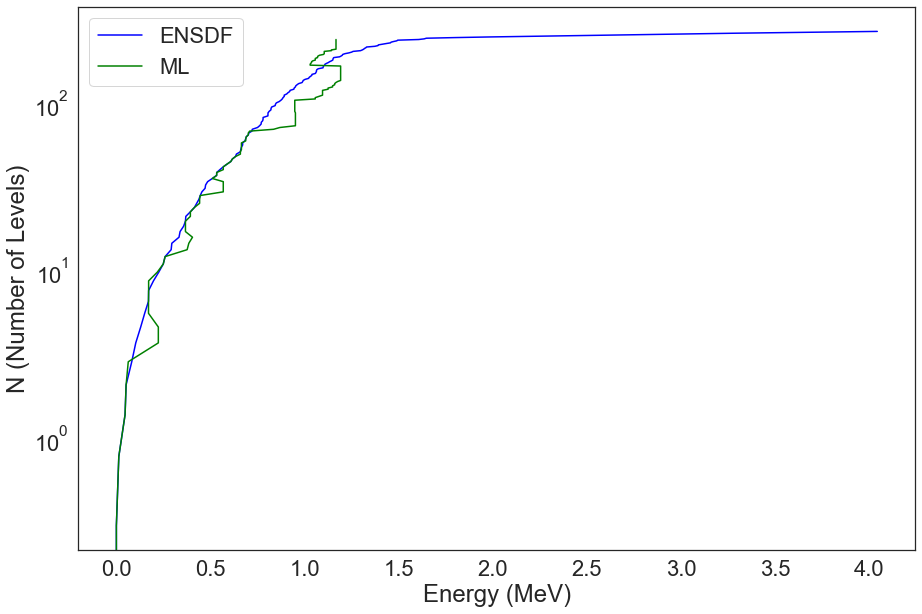

In [47]:
results_dict = ensdf_utils.predicting_nuclear_xs_v2(
    ensdf_df, 92, 235, dt_rgr, scaler, to_scale, log_sqrt=True, num_levels=140,
    plot=True, save=True, save_dir=figure_dir, inv_trans=True)

In [49]:
results_dict.keys()

dict_keys(['expanded', 'original', 'error_metrics'])

In [50]:
results_dict["error_metrics"]

,id,mae,mse,evs,mae_m,r2
0,EXFOR VS ML,0.094578,0.034748,0.696485,0.060688,0.684372


# Other

In [11]:
# tree_cut_mae = tree.DecisionTreeRegressor(max_depth=100, criterion='mae')
# tree_cut_mae.fit(x_train, y_train)
# print("The depth of the three is: ", tree_cut_mae.get_depth())

# tree_mae = tree.DecisionTreeRegressor(max_depth=100, criterion='mae')
# tree_mae.fit(x_train_2, y_train_2)
# print("The depth of the three is: ", tree_mae.get_depth())

# tree_cut_fried = tree.DecisionTreeRegressor(max_depth=100, criterion='friedman_mse')
# tree_cut_fried.fit(x_train, y_train)
# print("The depth of the three is: ", tree_cut_fried.get_depth())

# tree_fried = tree.DecisionTreeRegressor(max_depth=100, criterion='friedman_mse')
# tree_fried.fit(x_train_2, y_train_2)
# print("The depth of the three is: ", tree_fried.get_depth())

In [20]:
names = ["tree_cut_mae", "tree_mae", "tree_cut_fried", "tree_fried", "tree_cut_mse", "tree_mse"]
x = 0
for i in [tree_cut_mae, tree_mae, tree_cut_fried, tree_fried, tree_cut_mse, tree_mse]:
    predicting_nuclear_xs(17, 35-17, i, N=500, adopted=True, tf_dataset=False, save=True, name=names[x])
    x = x + 1

XS Tree vs EXFOR:
The MSE is:  6.845673947368706e-05
The R2-Score is:  0.9999628115024312
XS Tree vs EXFOR:
The MSE is:  21.601554699013157
The R2-Score is:  -10.73484700825521
XS Tree vs EXFOR:
The MSE is:  6.845673947368706e-05
The R2-Score is:  0.9999628115024312
XS Tree vs EXFOR:
The MSE is:  21.601554699013157
The R2-Score is:  -10.73484700825521
XS Tree vs EXFOR:
The MSE is:  6.845673947368706e-05
The R2-Score is:  0.9999628115024312
XS Tree vs EXFOR:
The MSE is:  21.601554699013157
The R2-Score is:  -10.73484700825521


In [120]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, tree_cut_mse, scaler, to_scale, 
                                               N=500, adopted=True, xg=False, save=True, name="Cl35_DT")

(38, 7)
To infer shape is  (538, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  0.015473414302631583
The R2-Score is:  0.9915942092100887


In [126]:
df.Element_w_A.value_counts(sort=True)[:25]

208Pb    187
32S      171
140La    167
122Te    162
124Te    152
166Ho    152
152Eu    151
128Xe    143
154Eu    128
176Lu    128
126Xe    128
112Cd    125
134Cs    119
125Xe    116
209Bi    114
180Ta    112
166Er    111
168Er    110
144Nd    101
87Sr      99
64Cu      96
63Cu      96
104Rh     95
134Ba     94
143Nd     94
Name: Element_w_A, dtype: int64

# XGBoost

In [179]:
import xgboost as xgb

In [180]:
dtrain = xgb.DMatrix(x_train.values, y_train.values)
dtest = xgb.DMatrix(x_test.values, y_test.values)

dtrain2 = xgb.DMatrix(x_train_2.values, y_train_2.values)
dtest2 = xgb.DMatrix(x_test_2.values, y_test_2.values)

evallist = [(dtest, 'eval'), (dtrain, 'train')]
evallist2 = [(dtest2, 'eval'), (dtrain2, 'train')]

In [108]:
# specify parameters via map
param = {'max_depth':2000, 'eta':0.1, 'objective':'reg:squarederror', "booster":"gbtree"}
num_round = 2000

progress = dict()
progress_raw = dict()

bst = xgb.train(param, dtrain, num_round, evallist, evals_result=progress, 
                verbose_eval=False, early_stopping_rounds=10)

bst_raw = xgb.train(param, dtrain2, num_round, evallist2, evals_result=progress_raw, 
                verbose_eval=False, early_stopping_rounds=10)

In [182]:
max_depths = [200]
etas = [0.1, 0.01]
num_rounds = [500]

progress = dict()
xgb_models = []

for x in max_depths:
    for y in etas:
        for z in num_rounds:
            param = {'max_depth':x, 'eta':y, 'objective':'reg:squarederror', "booster":"gbtree"}
            xgbs = xgb.train(param, dtrain, z, evallist, evals_result=progress, 
                verbose_eval=False, early_stopping_rounds=10)
            xgb_models.append(xgbs)

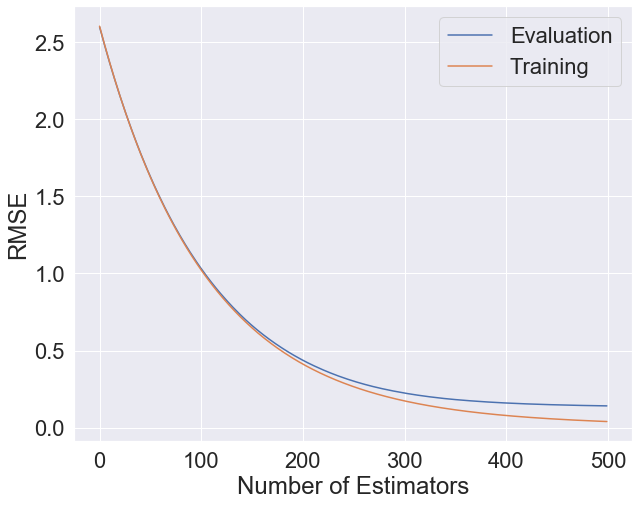

In [184]:
ensdf_plot.plot_xgb_training(progress, save=False, show=True)

To infer shape is  (538, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  0.010579310504753062
The R2-Score is:  0.9942528863336038
The MAE is:  0.05644529076852289
The Median-AE is:  0.04331683416366561


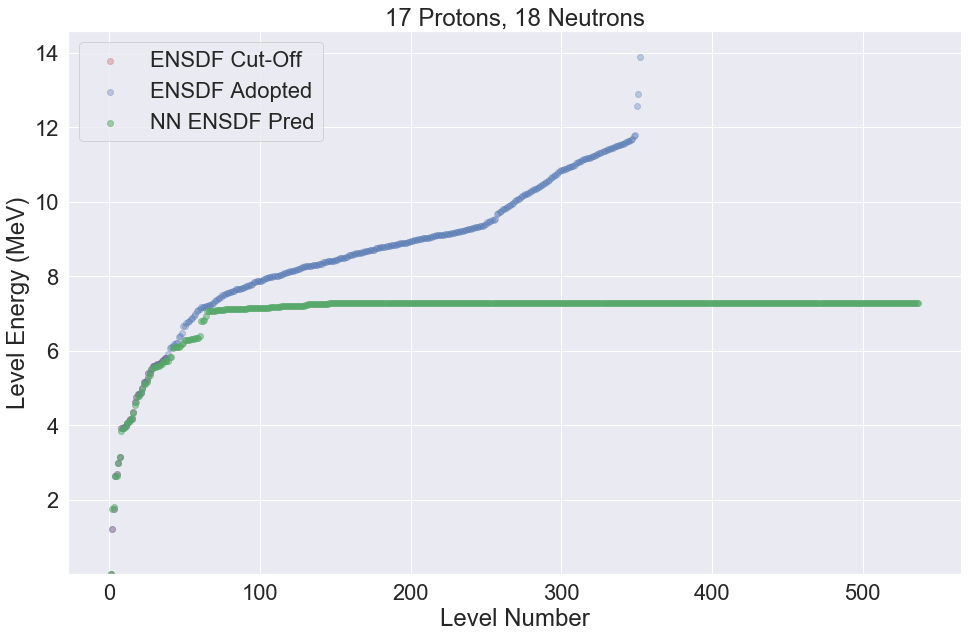

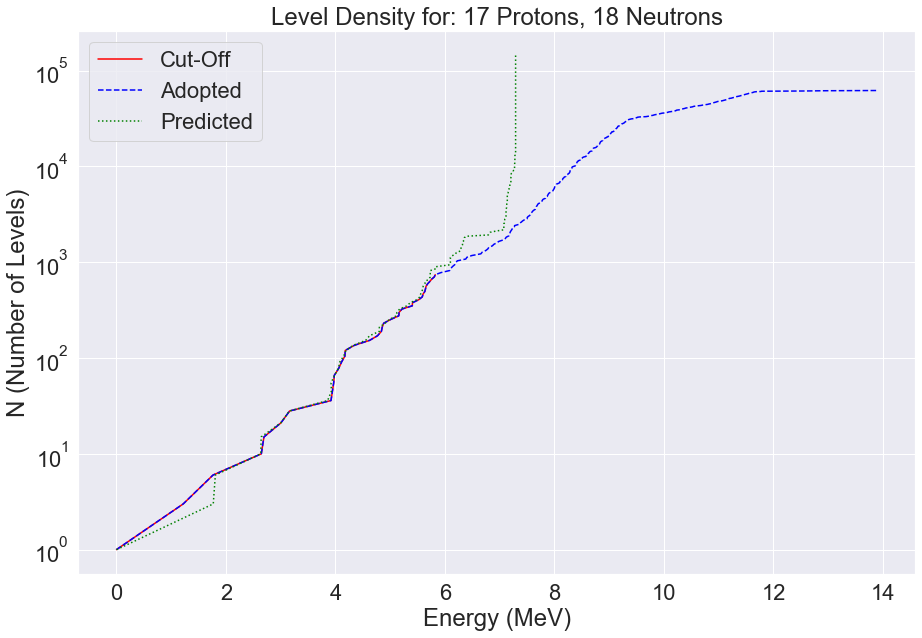

In [188]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, xgb_models[1], scaler, to_scale, 
                                               N=500, adopted=True, xg=True, save=False, name="Cl35")

In [137]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, bst_raw, scaler, to_scale, 
                                                   N=160, adopted=True, xg=True, save=True, 
                                                   name="Cl35_raw", show=False)

To infer shape is  (198, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  21.59982507197983
The R2-Score is:  -10.733907404189658


In [140]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 92, 235-92, bst, scaler, to_scale, 
                                               N=160, adopted=True, xg=True, save=False, name="U235", show=False)

To infer shape is  (213, 4)
To plot 2 shape is  (152, 7)
XS Tree vs EXFOR:
The MSE is:  2.060228628076473e-05
The R2-Score is:  0.9995838283158415


In [129]:
# bst.save_model('./Models/XGBoost/{}r_{}d_{}.model'.format(num_round, param["max_depth"], param["booster"]))

In [110]:
# bst = xgb.Booster()  # init model
# bst.load_model('0001.model')  # load data

In [50]:
# ax = xgb.plot_importance(bst)
# ax.figure.set_size_inches(10,8)

# Grid Search

In [174]:
# from sklearn.model_selection import GridSearchCV
# import pickle
# from sklearn.model_selection import ShuffleSplit

In [175]:
# # # Create the parameter grid: gbm_param_grid
# # gbm_param_grid = {
# #     'learning_rate': [0.3, 0.2, 0.1, 0.01],
# #     'n_estimators': [50, 100, 300, 1000],
# #     'max_depth': [2, 5, 100, 400, 1000]}

# # Create the parameter grid: gbm_param_grid
# gbm_param_grid = {
#     'learning_rate': [0.1],
#     'n_estimators': [1000],
#     'max_depth': [1000]}

# # Instantiate the regressor: gbm
# gbm = xgb.XGBRegressor(objective="reg:squarederror")

In [176]:
# # Perform grid search: grid_mse
# grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, 
#                         cv=ShuffleSplit(test_size=0.20, n_splits=1), verbose=5, n_jobs=-1)

# # ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)


# grid_mse.fit(df.drop(columns=["Level_Energy", "Level_Energy_SQRT", "Level_Number_SQRT", "Element_w_A"], axis=1),
#                      df[["Level_Energy"]])

# # Print the best parameters and lowest RMSE
# print("Best parameters found: ", grid_mse.best_params_)
# print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [168]:
# best_xgb = grid_mse.best_estimator_

In [ ]:
# bst.save_model('./Models/XGBoost/xgb_cv.model')

In [170]:
# predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, best_xgb, scaler, to_scale, 
#                                                N=500, adopted=True, xg=False, save=False, name="Cl35")

In [171]:
# from joblib import dump, load
# dump(BestRR1, '../ML_Data/Models/Decision_Trees/DT_GS.joblib') 

In [172]:
# clf = load('../ML_Data/Models/Decision_Trees/DT_GS.joblib') 

In [173]:
# cv_results = pd.DataFrame(Grid1.cv_results_)
# cv_results.to_csv("gridcv_results.csv", index=False)

# AdaBoost Regressor

In [122]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=2000), random_state=0, n_estimators=2000, loss="exponential", learning_rate=0.3)
regr.fit(x_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=2000,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

(38, 7)
To infer shape is  (538, 4)
To plot 2 shape is  (352, 7)
XS Tree vs EXFOR:
The MSE is:  0.015473414302631591
The R2-Score is:  0.9915942092100887


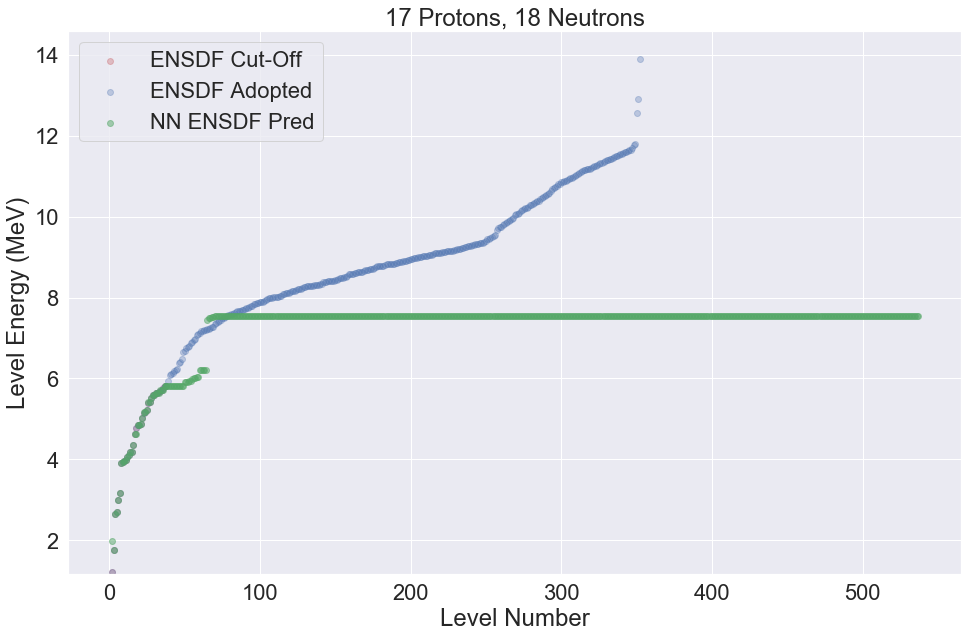

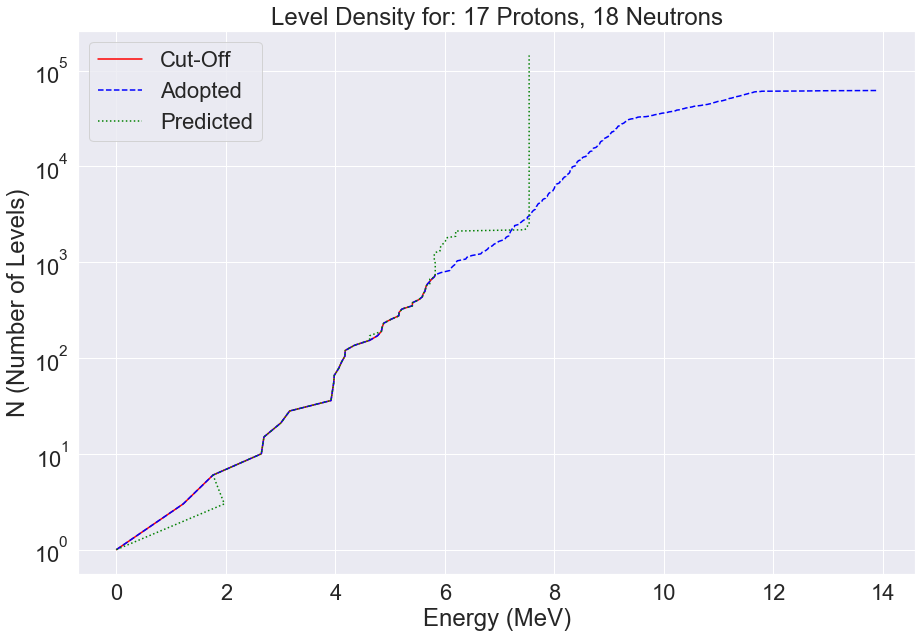

In [123]:
predictions = ensdf_plot.predicting_nuclear_levels(df, df2, 17, 35-17, regr, scaler, to_scale, 
                                               N=500, adopted=True, xg=False, save=False, name="Cl35_DT")